In [1]:
# --- 1. Importações ---
import pandas as pd
import numpy as np
import random
import time
import joblib
import json
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# --- 2. Carregamento e Preparação dos Dados ---
df = pd.read_csv('dataset_com_id.csv')

X = df.drop(['Target', 'ID'], axis=1)
y = df['Target']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Variáveis para armazenar resultados ---
lst_results_mlp = []
lst_results_rf = []
best_params_mlp = []
best_params_rf = []

training_times_mlp = []
training_times_rf = []

# Para guardar as predições da última execução (usar nas matrizes)
last_pred_mlp = None
last_pred_rf = None
last_best_mlp = None
last_best_rf = None
last_scaler = None

c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 


RELATÓRIO FINAL (Execução 30/30)

--- Modelo MLP (GridSearchCV) ---
Melhores parâmetros encontrados: {'activation': 'logistic', 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.001}
Melhor Score Médio (validação): 0.7635
              precision    recall  f1-score   support

     Dropout       0.77      0.71      0.74       284
    Enrolled       0.42      0.40      0.41       159
    Graduate       0.80      0.85      0.82       442

    accuracy                           0.73       885
   macro avg       0.66      0.65      0.66       885
weighted avg       0.72      0.73      0.72       885


--- Modelo Random Forest (GridSearchCV) ---
Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Melhor Score Médio (validação): 0.7785
              precision    recall  f1-score   support

     Dropout       0.81      0.76      0.79       284
    Enrolled       0.59      0.36      0.45       159
    Graduate       0.79      0.93      0.85       

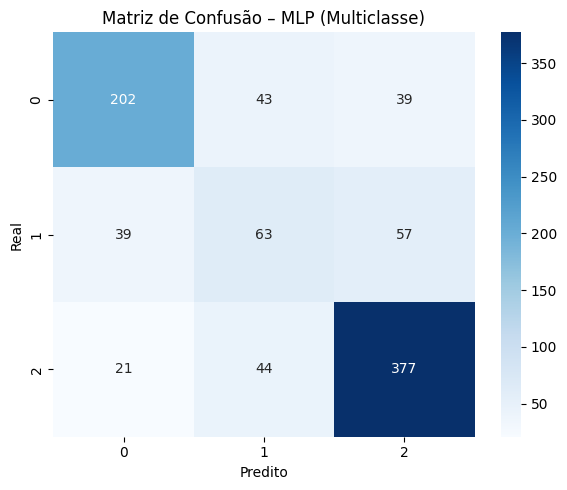

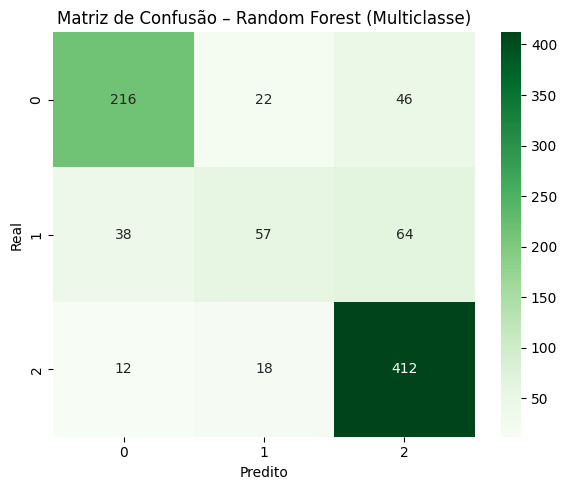

In [3]:
# --- 3. Loop de 30 execuções ---
for i in range(30):
    sd = i
    np.random.seed(sd)
    random.seed(sd)

    # Padronização (fit no treino)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------- MLP -----------------
    param_grid_mlp = {
        'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'activation': ['logistic', 'tanh', 'relu']
    }

    mlp = MLPClassifier(solver='adam', max_iter=1000, random_state=sd)

    start = time.time()
    grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, n_jobs=-1, verbose=0)
    grid_mlp.fit(X_train_scaled, y_train)
    training_times_mlp.append(time.time() - start)

    best_mlp = grid_mlp.best_estimator_
    best_params_mlp.append(grid_mlp.best_params_)

    pred_test_mlp = best_mlp.predict(X_test_scaled)
    acc_test_mlp = accuracy_score(y_test, pred_test_mlp)
    lst_results_mlp.append(acc_test_mlp)

    # ----------------- Random Forest -----------------
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    rf = RandomForestClassifier(random_state=sd+100)

    start = time.time()
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=0)
    grid_rf.fit(X_train, y_train)
    training_times_rf.append(time.time() - start)

    best_rf = grid_rf.best_estimator_
    best_params_rf.append(grid_rf.best_params_)

    pred_test_rf = best_rf.predict(X_test)
    acc_test_rf = accuracy_score(y_test, pred_test_rf)
    lst_results_rf.append(acc_test_rf)

    if i == 29:
        last_pred_mlp = pred_test_mlp
        last_pred_rf = pred_test_rf
        last_best_mlp = best_mlp
        last_best_rf = best_rf
        last_scaler = scaler  

        print("\n" + "="*50)
        print(f"RELATÓRIO FINAL (Execução {i+1}/30)")
        print("="*50)
        print("\n--- Modelo MLP (GridSearchCV) ---")
        print(f"Melhores parâmetros encontrados: {grid_mlp.best_params_}")
        print(f"Melhor Score Médio (validação): {grid_mlp.best_score_:.4f}")
        print(classification_report(y_test, pred_test_mlp, target_names=le.classes_))

        print("\n--- Modelo Random Forest (GridSearchCV) ---")
        print(f"Melhores parâmetros encontrados: {grid_rf.best_params_}")
        print(f"Melhor Score Médio (validação): {grid_rf.best_score_:.4f}")
        print(classification_report(y_test, pred_test_rf, target_names=le.classes_))
        print("="*50 + "\n")

        # Matrizes de confusão 
        cm_mlp = confusion_matrix(y_test, pred_test_mlp)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues")
        plt.title("Matriz de Confusão – MLP (Multiclasse)")
        plt.xlabel("Predito"); plt.ylabel("Real")
        plt.tight_layout()
        plt.savefig("matriz_confusao_mlp_multiclasse.png")
        plt.show()
        plt.close()

        cm_rf = confusion_matrix(y_test, pred_test_rf)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
        plt.title("Matriz de Confusão – Random Forest (Multiclasse)")
        plt.xlabel("Predito"); plt.ylabel("Real")
        plt.tight_layout()
        plt.savefig("matriz_confusao_rf_multiclasse.png")
        plt.show()
        plt.close()

In [4]:
# --- 4. Resultados Finais (estatísticas) ---
print("\n" + "="*60)
print("RESULTADO DAS 30 EXECUÇÕES")
print("="*60)

mlp_mean = np.mean(lst_results_mlp)
mlp_std = np.std(lst_results_mlp)
rf_mean = np.mean(lst_results_rf)
rf_std = np.std(lst_results_rf)

print(f"\nModelo MLP")
print(f"Acurácia Média no Conjunto de Teste : {mlp_mean:.4f}")
print(f"Desvio Padrão (Acurácia)             : {mlp_std:.4f}")

print(f"\nModelo Random Forest")
print(f"Acurácia Média no Conjunto de Teste : {rf_mean:.4f}")
print(f"Desvio Padrão (Acurácia)             : {rf_std:.4f}")


RESULTADO DAS 30 EXECUÇÕES

Modelo MLP
Acurácia Média no Conjunto de Teste : 0.7473
Desvio Padrão (Acurácia)             : 0.0093

Modelo Random Forest
Acurácia Média no Conjunto de Teste : 0.7762
Desvio Padrão (Acurácia)             : 0.0047


In [5]:
# --- 5. Resumo dos Parâmetros ---
print("\n" + "-"*60)
print("RESUMO DOS PARÂMETROS (MLP)")
print("-"*60)
param_strs_mlp = [json.dumps(p, sort_keys=True) for p in best_params_mlp]
most_common_params_mlp = Counter(param_strs_mlp).most_common(3)
print("\nParâmetros mais recorrentes entre as 30 execuções:")
for params, count in most_common_params_mlp:
    print(f"{count} vezes → {params}")

print("\n" + "-"*60)
print("RESUMO DOS PARÂMETROS (Random Forest)")
print("-"*60)
param_strs_rf = [json.dumps(p, sort_keys=True) for p in best_params_rf]
most_common_params_rf = Counter(param_strs_rf).most_common(3)
print("\nParâmetros mais recorrentes entre as 30 execuções:")
for params, count in most_common_params_rf:
    print(f"{count} vezes → {params}")


------------------------------------------------------------
RESUMO DOS PARÂMETROS (MLP)
------------------------------------------------------------

Parâmetros mais recorrentes entre as 30 execuções:
18 vezes → {"activation": "logistic", "hidden_layer_sizes": [10], "learning_rate_init": 0.001}
6 vezes → {"activation": "relu", "hidden_layer_sizes": [10], "learning_rate_init": 0.001}
3 vezes → {"activation": "logistic", "hidden_layer_sizes": [20], "learning_rate_init": 0.001}

------------------------------------------------------------
RESUMO DOS PARÂMETROS (Random Forest)
------------------------------------------------------------

Parâmetros mais recorrentes entre as 30 execuções:
12 vezes → {"max_depth": 20, "min_samples_split": 2, "n_estimators": 200}
5 vezes → {"max_depth": null, "min_samples_split": 2, "n_estimators": 200}
3 vezes → {"max_depth": null, "min_samples_split": 2, "n_estimators": 100}


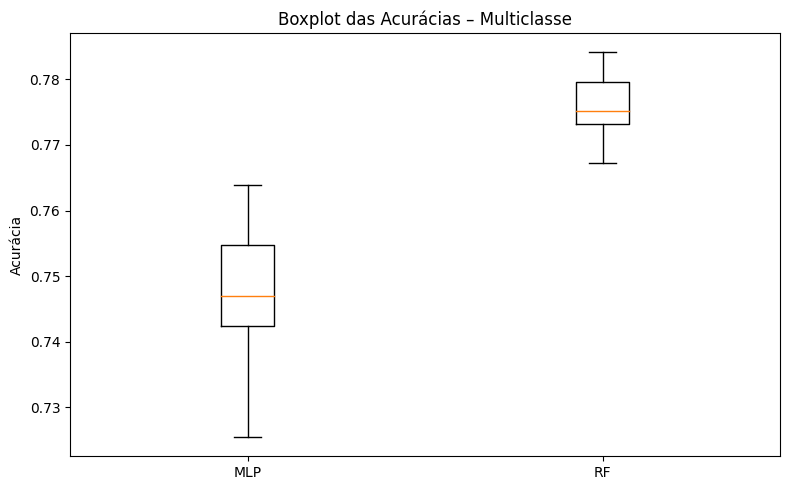

In [6]:
# --- 6. Boxplot das acurácias ---
plt.figure(figsize=(8,5))
plt.boxplot([lst_results_mlp, lst_results_rf], labels=['MLP', 'RF'])
plt.title("Boxplot das Acurácias – Multiclasse")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

In [9]:
# --- 7. CSV com resultados e tempos ---
df_csv = pd.DataFrame({
    "accuracy_mlp": lst_results_mlp,
    "accuracy_rf": lst_results_rf,
    "tempo_mlp": training_times_mlp,
    "tempo_rf": training_times_rf
})
df_csv.to_csv("resultados_multiclasse.csv", index=False)
print("CSV salvo: resultados_multiclasse.csv")

CSV salvo: resultados_multiclasse.csv


In [12]:
# --- 8. Salvamento dos modelos e objetos para a aplicação ---
# Salvamos os objetos da ÚLTIMA execução (melhores estimadores + scaler + encoder + stats)
if last_best_mlp is not None and last_best_rf is not None and last_scaler is not None:
    joblib.dump(last_best_mlp, "mlp_multiclasse.pkl")
    joblib.dump(last_best_rf, "rf_multiclasse.pkl")
    joblib.dump(last_scaler, "scaler_multiclasse.pkl")
    joblib.dump(le, "label_encoder_multiclasse.pkl")

    # Estatísticas completas do MLP
    mlp_stats = {
        "loss_curve": list(getattr(last_best_mlp, "loss_curve_", [])),
        "n_iter": getattr(last_best_mlp, "n_iter_", None),
        "layers": last_best_mlp.hidden_layer_sizes,
        "activation": last_best_mlp.activation,
        "learning_rate_init": last_best_mlp.learning_rate_init
    }
    joblib.dump(mlp_stats, "mlp_stats_multiclasse.pkl")

    # Estatísticas completas do Random Forest
    rf_stats = {
        "feature_importances": getattr(last_best_rf, "feature_importances_", None).tolist(),
        "n_estimators": last_best_rf.n_estimators,
        "max_depth": last_best_rf.max_depth,
        "min_samples_split": last_best_rf.min_samples_split
    }
    joblib.dump(rf_stats, "rf_stats_multiclasse.pkl")
    print("\nArquivos exportados com sucesso!")
    print("- mlp_multiclasse.pkl")
    print("- rf_multiclasse.pkl")
    print("- scaler_multiclasse.pkl")
    print("- label_encoder_multiclasse.pkl")
    print("- mlp_stats_multiclasse.pkl")
    print("- rf_stats_multiclasse.pkl")
    print("- matrizes de confusão PNG")
    print("- resultados_multiclasse.csv")


    print("Modelos e artefatos salvos (mlp_multiclasse.pkl, rf_multiclasse.pkl, scaler_multiclasse.pkl, label_encoder_multiclasse.pkl)")
    print("Estatísticas salvas (mlp_stats_multiclasse.pkl, rf_stats_multiclasse.pkl)")

else:
    print("Aviso: modelos finais não estão disponíveis para salvar (executou menos de 30 iterações?).")


Arquivos exportados com sucesso!
- mlp_multiclasse.pkl
- rf_multiclasse.pkl
- scaler_multiclasse.pkl
- label_encoder_multiclasse.pkl
- mlp_stats_multiclasse.pkl
- rf_stats_multiclasse.pkl
- matrizes de confusão PNG
- resultados_multiclasse.csv
Modelos e artefatos salvos (mlp_multiclasse.pkl, rf_multiclasse.pkl, scaler_multiclasse.pkl, label_encoder_multiclasse.pkl)
Estatísticas salvas (mlp_stats_multiclasse.pkl, rf_stats_multiclasse.pkl)
